2025-03-31 13:49:57.915 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-31 13:49:57.918 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-31 13:49:57.919 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-31 13:49:57.919 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-31 13:49:57.920 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-31 13:49:57.927 WARNING streamlit.run

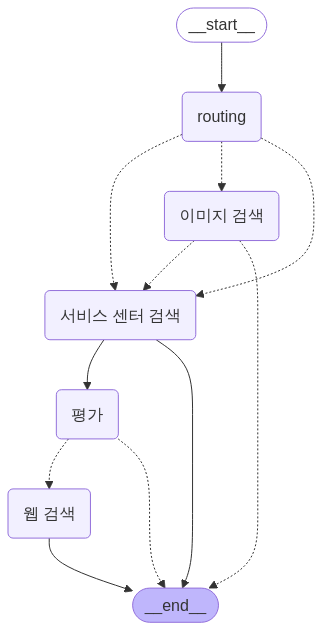

In [13]:
# Description: AI agent를 구성하는 모듈
import os, requests, openai, re
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage
from langchain.tools import tool
from typing import List

from langchain.chains.summarize import load_summarize_chain
from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore

from typing import List, Optional
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_community.tools import TavilySearchResults
from langchain.tools import tool
from langchain.docstore.document import Document
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal

from config import IMAGE_PATTERN, st
from embedding_service import index_data

# ==========================================
# 설정 및 초기화
# ==========================================
load_dotenv()

model = "gpt-4o"
llm = ChatOpenAI(model=model)
embedding = OpenAIEmbeddings(model="text-embedding-3-large") # text-embedding-ada-002, text-embedding-3-large

class AgentState(TypedDict, total=False):
    messages: List[HumanMessage]
    image: Optional[str]
    index: str

# --- 요약 함수 추가 ---
def summarize_text(text):
    # 입력 텍스트를 Document 객체로 감싸기
    docs = [Document(page_content=text)]
    
    # map 단계 프롬프트 (각 문서를 요약할 때)
    map_prompt_template = (
        "다음 내용을 한국어로 간결하게 요약해 주세요:\n\n{text}\n\n요약:"
    )
    map_prompt = PromptTemplate(template=map_prompt_template, input_variables=["text"])
    
    # combine 단계 프롬프트 (여러 요약을 종합할 때)
    combine_prompt_template = (
        "다음은 여러 문서의 요약입니다. 이를 종합하여 한국어로 한 문장으로 요약해 주세요:\n\n{text}\n\n최종 요약:"
    )
    combine_prompt = PromptTemplate(template=combine_prompt_template, input_variables=["text"])
    
    # 요약 체인 생성 (map_reduce 체인)
    chain = load_summarize_chain(
        llm, 
        chain_type="map_reduce", 
        map_prompt=map_prompt, 
        combine_prompt=combine_prompt
    )
    summary = chain.run(docs)
    return summary

# ==========================================
# KakaoMap 검색을 수행하는 Tool 추가
# ==========================================
@tool
def kakao_map_search_tool(query: str) -> str:
    """
    사용자의 위치(예: lat/lon)와 검색어를 받아,
    카카오맵에서 가까운 장소를 찾아주는 예시 함수.
    query 예시: 'lat=37.499,lon=127.0264,KCC오토 서비스센터'
    """
    kakao_api_key = os.getenv("KAKAO_REST_API_KEY")
    if not kakao_api_key:
        return "카카오 API 키가 설정되지 않았습니다."

    parts = query.split(",")
    if len(parts) < 3:
        return "쿼리 형식이 잘못되었습니다. 예: 'lat=37.499,lon=127.0264,KCC오토 서비스센터'"

    lat_part = parts[0].replace("lat=","").strip()
    lon_part = parts[1].replace("lon=","").strip()
    keyword = parts[2].strip()

    url = "https://dapi.kakao.com/v2/local/search/keyword.json"
    headers = { "Authorization": f"KakaoAK {kakao_api_key}" }
    params = {
        "query": keyword,
        "x": lon_part,  # 카카오맵은 x=경도, y=위도
        "y": lat_part,
        "radius": 20000  # 예: 반경 20km
    }

    try:
        response = requests.get(url, headers=headers, params=params)
        data = response.json()
        if "documents" not in data or not data["documents"]:
            return "검색 결과가 없습니다."

        docs = data["documents"][:3]
        result_lines = []
        for d in docs:
            place_name = d["place_name"]
            address = d["road_address_name"] or d["address_name"]
            phone = d["phone"]
            place_url = d.get("place_url", "")  # 카카오맵 상세 페이지 링크
            line = (
                f"- {place_name}  \n"  # ← 뒤에 스페이스 2칸 + 개행
                f"  주소: {address}  \n"
                f"  전화: {phone}  \n"
            )
            if place_url:
                line += f"  [카카오맵 링크]({place_url})  \n"


            result_lines.append(line)

        final_str = "\n".join(result_lines)
        return f"[가까운 KCC오토 서비스센터 검색 결과]\n\n{final_str}"

    except Exception as e:
        return f"카카오맵 검색 중 오류: {e}"

# ==========================================
# 3) "가까운 서비스 센터" 노드
# ==========================================
def service_center_search_node(state: AgentState) -> Command:
    # 1) ...KakaoMap 툴 호출...
    raw_result = kakao_map_search_tool(f"lat=37.499,lon=127.0264,kcc 벤츠 서비스")

    # 2) raw_result를 파싱하거나, 여기서는 그냥 문자열 붙이기
    final_answer = """\

    
### 가까운 KCC오토 서비스 센터
다음은 가까운 메르세데스 벤츠 KCC오토 서비스 센터 목록입니다. 차량 점검 및 수리를 위한 서비스 제공이 가능합니다.

""" + raw_result + """


위 서비스 센터에서는 정기 점검, 자동차 수리 및 기타 다양한 서비스를 제공합니다. 
필요에 따라 미리 전화로 예약하시기를 권장합니다.

[출처: 카카오맵]
"""
    # 3) 메시지에 저장
    state["service_center_result"] = final_answer
    state.setdefault("messages", []).append(
        HumanMessage(content=final_answer, name="서비스 센터 검색")
    )
    return Command(update={'messages': state["messages"]})

# ==========================================
# lang_graph 정의
# ==========================================
# 여기 **위쪽**에 있던 `retrieve_or_image_node`는 제거하거나 주석 처리하고,
# **이 아래쪽**의 함수만 사용!
def routing_node(state: AgentState) -> Command[Literal["내부 데이터 검색", "이미지 검색", "서비스 센터 검색"]]:
    try:
        user_query = state["messages"][-1]["content"]
        state["index"] = None
        state["index"] = index_data()
        
        # 0) "가까운 서비스 센터" 키워드 감지
        if ("가까운 서비스 센터" in user_query) or ("근처 서비스 센터" in user_query) or ("서비스 센터" in user_query):
            return Command(update={'messages': state['messages']}, goto="서비스 센터 검색")

        # 1) 이미지 체크
        if state["image"]:
            return Command(update={'messages': state['messages'], 'image': state['image'], 'index': state['index']}, goto="이미지 검색")

        # 2) 그 외는 text search
        return Command(update={'messages': state['messages'], 'index': state['index']}, goto="내부 데이터 검색")
    except Exception as e:
        st.error(f"라우팅 노드에서 에러가 발생했습니다. 다시 시도해주세요. {e}")

def image_search_node(state: AgentState) -> Command[Literal['내부 데이터 검색', END]]:
    try:
        st.write("이미지를 분석하는중입니다...")
        def generate_image_llm_output(user_question, data_url):
            response = openai.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {
                                "type": "text",
                                "text": (
                                    f"""You are a highly experienced professional specializing in Mercedes Benz {state['index']} car manuals.
Your role is to provide concise and precise answers directly related to the user's specific question and the provided image.
When a user provides an image along with a question, analyze the image specifically in relation to the user's question, and answer explicitly to that question only.
DO NOT include any additional information that the user did not specifically ask for.
If your question contains a specific description, such as a particular color or location, make sure to find only the elements that exactly match that description and write your answer.
Never include other colors, other locations, or information that you have not clearly requested.
If the user's question asks specifically about a term, feature, or function in the image, explain only that term, feature, or function clearly and briefly.
If a non-vehicle-related, blurred, or inappropriate image is entered, please respond with a message starting with 'NO:' and explain why the image is unacceptable.
Translate the entire answer into Korean, except for responses starting with 'NO:'.
Ensure each section is clearly separated by new lines, and present the final answer in an organized and professional manner in Korean.​"""
)
                            },
                            {
                                "type": "image_url",
                                "image_url": {"url": data_url}
                            }
                        ]
                    }
                ]
            )
            # message는 dict 형태이므로, content 필드를 인덱싱으로 가져옵니다.
            return response.choices[0].message.content
        
        image_search_result = generate_image_llm_output(
            user_question=state["messages"][-1]["content"],
            data_url=state["image"]
        )
        
        if image_search_result.lower().startswith("no:"):
            return Command(update={'messages': image_search_result}, goto=END)
        state["image"] = image_search_result
        return Command(update={'messages': state["messages"], 'image': state["image"]}, goto="내부 데이터 검색")
    except Exception as e:
        st.error(f"이미지 검색 노드에서 에러가 발생했습니다. 다시 시도해주세요. {e}")

@tool
def vector_retrieve_tool(query: str, index: str) -> List[Document]:
    """Retrieve documents based on the given query."""
    database = PineconeVectorStore(index_name=index, embedding=embedding)
    return database.as_retriever(search_kwargs={"k": 3}).invoke(query)

def dynamic_state_modifier(agent_input: AgentState) -> str:
    image_val = agent_input["image"]
    image_line = f"The Topic of the provided target image is {image_val}. " if image_val and image_val != "no_image" else ""
    car_type = st.session_state.get("car_type", "EQS")
    index = agent_input.get("index", "eqs")
    return (
        f"""You are a highly experienced professional who specializes in the Mercedes-Benz {car_type} vehicle manual.
Your role is to write systematic and clear answers so that users can easily understand vehicle features.
Based on only the information provided, a fact-based, research result-based answer is prepared, and personal opinions are excluded.
Make sure to write in Korean according to the instructions below and separate each section into separate lines.

[Information Index]
- Index name: {index}
- {image_line}

[Writing structure]

## {{subject}}
- Write a concise and accurate title that implies a function or key characteristic.
  (e.g. "Driver Display Charge Status Window Function")

### {{Detailed Description}}
- Provide a comprehensive explanation of the questions, including the operating principles, benefits, and technical specifications of the function.
- The description shall be organized in paragraph or bullet point format, and if the information is presented as a number (e.g., "1".", "2.", etc.), the corresponding numbering format shall remain the same.
- If you have any relevant examples or references, include them so that the reader has a clear understanding of the features.
- If there is an image directly related to the information provided, insert the image link alone in a separate line without further explanation.
- Answers must be based on the information provided and do not include external information or personal opinions."""
    )

def retrieve_search_node(state: AgentState) -> Command:
    try:
        st.write("질문을 분석하고 있습니다...")

        original_question = state["messages"][-1]["content"]
        # 질문 교정 프롬프트
        correction_prompt = PromptTemplate.from_template(
            """You are an expert in charge of AI explaining Mercedes Benz vehicle manual.
Your role is to calibrate questions so that LLM can understand questions more effectively and find accurate information.
Don't change the intention of the question, but please improve the expression more accurately and specifically so that LLM can understand it well.
Please answer the corrected answer in Korean.

User's question: "{question}"

a calibrated question:"""
        )

        # LLM을 이용하여 질문 교정 수행
        correction_chain = correction_prompt | llm
        corrected_question = correction_chain.invoke({"question": original_question}).content.strip()
        # 교정된 질문을 상태에 저장
        state["messages"][-1]["content"] = corrected_question
        st.write(f"교정된 질문: {corrected_question}")

        st.write("내부 데이터를 검색하는중입니다...")
        st.session_state.car_type = state["index"]
        retrieve_search_agent = create_react_agent(
            llm,
            tools=[vector_retrieve_tool],
            state_modifier=dynamic_state_modifier(state)  # 함수로 교체
        )
        result = retrieve_search_agent.invoke(state)
        # 내부 retrieval 결과를 상태에 저장
        state["retrieve_result"] = result['messages'][-1].content

        if state["image"] and "retrieve_result" in state:
            state["retrieve_result"] = '\n'.join(
                line for line in state["retrieve_result"].split('\n')
                if not re.search(r'(https?://\S+|관련 이미지)', line)
            ).strip()
        
        # 기존 messages 리스트에 retrieval 결과를 추가
        state.setdefault("messages", []).append(
            HumanMessage(content=state["retrieve_result"], name="내부 데이터 검색")
        )
        # 전체 messages 리스트를 업데이트
        return Command(update={'messages': state["messages"]})
    except Exception as e:
        st.error(f"retrieve 노드에서 에러가 발생했습니다. 다시 시도해주세요. {e}")

def evaluate_node(state: AgentState) -> Command[Literal['웹 검색', END]]:
    try:
        retrieve_result = state["messages"][-1].content
        
        if retrieve_result == "":
            st.write("검색 결과가 없습니다. 웹 검색을 시도합니다.")
            return Command(goto='웹 검색')
        
        car_type = st.session_state.get("car_type", "EQS")
        # 2) 평가 프롬프트 (명확히 'yes'/'no'만 출력하도록 지시)
        eval_prompt = PromptTemplate.from_template(

            f"""Retrieve Results:
{retrieve_result}
        
Purpose:
Evaluate the Mercedes-Benz {car_type} vehicle manual to ensure that the end-user answers are appropriate. The assessment will focus on the quality of the content and structure.

Evaluation criteria:
    Structural completeness of the description:
        - Evaluate that the answer is not just a list of sentences, but rather a logical flow of function description → how it works → examples of use or precautions.
        - e.g. Once you have outlined the features, you will be judged to be a good structural completion if you have systematically described the usage, operation principles, additional tips, or precautions.
    References to associated features:
        - When describing a particular function, assess that any other function or useful additional information related to that function, such as safety features, assistive systems, etc. are mentioned together.
        - For example, if the forward collision warning feature includes a description of the lane keeping assistance or association with adaptive cruise control, give a positive assessment.
    Content fidelity and accuracy:
        - Evaluate that your answers provide sufficient, accurate, and specific information about your questions.
        - For example, it covers the core of the question without fail, and it is rated well if it contains all the details necessary for the user to understand the features (operating principles, exceptions, relevant features, etc.).
    Solution completeness:
    - Evaluate that the answer provides a tangible and actionable solution to the user's question. The response should include specific recommendations, steps, or guidance—even if the manual itself lacks such information—to ensure that the end-user receives a useful resolution. If the answer only gives vague advice such as "전문가에게 문의" without detailed steps or alternatives, this criterion is considered not met.
Evaluation Method and Final Judgment:
        - After reviewing the satisfaction of the answers for each criterion, the final decision is made as follows.
        - If all criteria (structural completeness, associated feature references, content fidelity and accuracy, and solution completeness) are sufficiently met, output "no".
        (This means that the search results are sufficiently appropriate as end-user answers and no additional supplementation is required.)
        - If one or more criteria are not met and the content is insufficient or missing relevant information, output "yes".
        (This means that the search results are inappropriate as the final answer and require additional supplementation or rediscovering.)

Exception:
    - If the retrieved answer originates directly from the official Mercedes-Benz {car_type} manual and is accompanied by one or more image URLs that visually supplement the content, then consider the answer as sufficiently complete, and output "no" even if the solution completeness criterion seems marginal.

Final Answer:
Be sure to output the final result as "yes" or "no" in just one word after the evaluation."""
)
        eval_chain = eval_prompt | llm
        evaluation = eval_chain.invoke({"result": state.get("retrieve_result")})

        if "yes" in evaluation.content.lower():
            st.write("답변이 충분하지 않습니다. 웹 검색을 시도합니다.")
            return Command(goto='웹 검색')
        else:
            return Command(update={"message": retrieve_result}, goto=END)
    except Exception as e:
        st.error(f"evaluate 노드에서 에러가 발생했습니다. 다시 시도해주세요. {e}")

def web_search_node(state: AgentState) -> Command:
    try:
        tavily_search_tool = TavilySearchResults(
            max_results=5,
            search_depth="advanced",
            include_answer=True,
            include_raw_content=True,
            include_images=True,
        )

        car_type = st.session_state.get("car_type", "EQS")
        web_search_agent = create_react_agent(
            llm, 
            tools=[tavily_search_tool],
            state_modifier = (f"""
You are a highly experienced professional specializing in Mercedes Benz {car_type} car manuals.
Your role is to write your answers coherently so that users can easily understand the features.
To do this, please follow the following structure.
Based solely on the provided website information, please generate a comprehensive, fact-based, and detailed response.
Your answer must be fully translated into Korean, free from personal opinions, and organized using the structure below.
**Do not include any image references or display any images in your answer, even if they appear in the source information.**\

**For maintenance information**:
If you need to provide maintenance information, please refer to AUTODOC's maintenance site:
- https://club.autodoc.co.uk/manuals

## {{제목}}
- Provide a concise title that encapsulates the key feature or function.
(Example: 'Driver Display Charge Status Window Function')

### {{상세 설명}}
- Deliver a thorough explanation of the feature, including technical details, benefits, and practical usage instructions.
- If applicable, include any relevant references or source information from the website.
- IMPORTANT: Add the site URL where the knowledge was found after each knowledge found in the URL.
(Replace 실제_출처_URL with the actual URL found in the source; do not use a placeholder.)
At this point, the URL should have an accessible site that is accessible to the user and can check the internal content.

Keep in mind that the URL of the website from which you found the answer must be written.
Please ensure that each section is clearly separated by new lines and that the final answer is presented in an organized and professional manner in Korean."""
    )
)

        result = web_search_agent.invoke(state)
        state["web_result"] = result['messages'][-1].content
        state.setdefault("messages", []).append(
            HumanMessage(content=state["web_result"], name="웹 검색")
        )
        # 웹 검색 결과 도착 후, 만약 placeholder가 있다면 제거합니다.
        if "web_search_placeholder" in st.session_state:
            st.session_state.web_search_placeholder.empty()
            del st.session_state["web_search_placeholder"]
        return Command(update={'messages': state["messages"]})
    except Exception as e:
        st.error(f"웹 검색 노드에서 에러가 발생했습니다. 다시 시도해주세요. {e}")

# 그래프 구성
graph_builder = StateGraph(AgentState)
graph_builder.add_node("내부 데이터 검색", retrieve_search_node)
graph_builder.add_node("평가", evaluate_node)
graph_builder.add_node("웹 검색", web_search_node)
graph_builder.add_node("이미지 검색", image_search_node)
graph_builder.add_node("routing", routing_node)
graph_builder.add_node("서비스 센터 검색", service_center_search_node)

# 엣지 연결
graph_builder.add_edge(START, "routing")
graph_builder.add_edge("서비스 센터 검색", END)
graph_builder.add_edge("내부 데이터 검색", "평가")
graph_builder.add_edge("웹 검색", END)

graph = graph_builder.compile()
graph

In [10]:
# ==========================================
# KakaoMap 검색을 수행하는 Tool 추가
# ==========================================
@tool
def kakao_map_search_tool(query: str) -> str:
    """
    사용자의 위치(예: lat/lon)와 검색어를 받아,
    카카오맵에서 가까운 장소를 찾아주는 예시 함수.
    query 예시: 'lat=37.499,lon=127.0264,KCC오토 서비스센터'
    """
    kakao_api_key = os.getenv("KAKAO_REST_API_KEY")
    if not kakao_api_key:
        return "카카오 API 키가 설정되지 않았습니다."

    parts = query.split(",")
    if len(parts) < 3:
        return "쿼리 형식이 잘못되었습니다. 예: 'lat=37.499,lon=127.0264,KCC오토 서비스센터'"

    lat_part = parts[0].replace("lat=","").strip()
    lon_part = parts[1].replace("lon=","").strip()
    keyword = parts[2].strip()

    url = "https://dapi.kakao.com/v2/local/search/keyword.json"
    headers = { "Authorization": f"KakaoAK {kakao_api_key}" }
    params = {
        "query": keyword,
        "x": lon_part,  # 카카오맵은 x=경도, y=위도
        "y": lat_part,
        "radius": 20000  # 예: 반경 20km
    }

    try:
        response = requests.get(url, headers=headers, params=params)
        data = response.json()
        if "documents" not in data or not data["documents"]:
            return "검색 결과가 없습니다."

        docs = data["documents"][:3]
        result_lines = []
        for d in docs:
            place_name = d["place_name"]
            address = d["road_address_name"] or d["address_name"]
            distance = d.get("distance", "?")  # meter 단위
            phone = d["phone"]
            place_url = d.get("place_url", "")  # 카카오맵 상세 페이지 링크

            # Markdown 링크 형태로 넣어줍니다.
            # "[카카오맵 링크](https://...)" 형식
            line = (
                f"- {place_name} (거리: {distance}m)  \n"  # ← 뒤에 스페이스 2칸 + 개행
                f"  주소: {address}  \n"
                f"  전화: {phone}  \n"
            )
            if place_url:
                line += f"  [카카오맵 링크]({place_url})  \n"


            result_lines.append(line)

        final_str = "\n".join(result_lines)
        return f"[가까운 KCC오토 서비스센터 검색 결과]\n{final_str}"

    except Exception as e:
        return f"카카오맵 검색 중 오류: {e}"

# ==========================================
# 3) "가까운 서비스 센터" 노드
# ==========================================
def service_center_search_node(state: AgentState) -> Command:
    # 1) ...KakaoMap 툴 호출...
    raw_result = kakao_map_search_tool("lat=37.499,lon=127.0264,KCC오토 서비스센터")

    # 2) raw_result를 파싱하거나, 여기서는 그냥 문자열 붙이기
    final_answer = """\

    
### 가까운 KCC오토 서비스 센터
다음은 가까운 메르세데스 벤츠 KCC오토 서비스 센터 목록입니다. 차량 점검 및 수리를 위한 서비스 제공이 가능합니다.

""" + raw_result + """


위 서비스 센터에서는 정기 점검, 자동차 수리 및 기타 다양한 서비스를 제공합니다. 
필요에 따라 미리 전화로 예약하시기를 권장합니다.

[출처: 카카오맵]
"""
    # 3) 메시지에 저장
    state["service_center_result"] = final_answer
    state.setdefault("messages", []).append(
        HumanMessage(content=final_answer, name="service_center_search")
    )
    return Command(update={'messages': state["messages"]}, goto="evaluate")


In [ ]:
# ==========================================
# lang_graph 정의
# ==========================================
# 여기 **위쪽**에 있던 `retrieve_or_image_node`는 제거하거나 주석 처리하고,
# **이 아래쪽**의 함수만 사용!
def routing_node(state: AgentState) -> Command[Literal["retrieve_search", "image_search", "service_center_search"]]:
    try:
        user_query = state["messages"][0]["content"]
        state["index"] = None
        state["index"] = index_data()
        
        # 0) "가까운 서비스 센터" 키워드 감지
        if ("가까운 서비스 센터" in user_query) or ("근처 서비스 센터" in user_query):
            return Command(update={'messages': state['messages']}, goto="service_center_search")

        # 1) 이미지 체크
        match = re.search(IMAGE_PATTERN, user_query, flags=re.IGNORECASE)
        if match:
            image_url = match.group(0)
            updated_query = re.sub(IMAGE_PATTERN, '', user_query, count=1, flags=re.IGNORECASE).strip()
            state["messages"][0]["content"] = updated_query
            state["image"] = image_url
            return Command(update={'messages': state['messages'], 'image': state['image'], 'index': state['index']}, goto="image_search")

        # 2) 그 외는 text search
        return Command(update={'messages': state['messages'], 'index': state['index']}, goto="retrieve_search")
    except Exception as e:
        st.error(f"라우팅 노드에서 에러가 발생했습니다. 다시 시도해주세요. {e}")


def image_search_node(state: AgentState) -> Command:
    try:
        target_image_path = state["image"]
        target_image = Image.open(target_image_path).convert("RGB")

        # 저장된 아이콘 이미지 임베딩 로딩 또는 계산 함수
        def compute_and_save_embeddings():
            embeddings = {}
            for filename in os.listdir(icon_folder):
                if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
                    continue
                image_path = os.path.join(icon_folder, filename)
                # imread_unicode와 resize_image는 사용자의 이미지 전처리 함수라고 가정합니다.
                img_cv = imread_unicode(image_path)
                if img_cv is None:
                    continue
                img_cv = resize_image(img_cv, max_dim=500)
                # 이미지 전처리 (PIL 이미지로 변환 후 CLIP 전처리)
                img_pil = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
                input_tensor = preprocess(img_pil).unsqueeze(0).to(device)
                with torch.no_grad():
                    embedding = model.encode_image(input_tensor)
                embedding /= embedding.norm(dim=-1, keepdim=True)
                embeddings[filename] = embedding.cpu()  # CPU로 이동하여 저장
            # 임베딩 저장 (pickle 사용)
            with open(embeddings_path, "wb") as f:
                pickle.dump(embeddings, f)
            
        def load_embeddings():
            if os.path.exists(embeddings_path):
                with open(embeddings_path, "rb") as f:
                    embeddings = pickle.load(f)
                return embeddings
            else:
                return None

        # 저장된 임베딩이 없다면 계산하고 저장
        icon_embeddings = load_embeddings()
        if icon_embeddings is None:
            compute_and_save_embeddings()
            icon_embeddings = load_embeddings()

        # 타겟 이미지 전처리 및 임베딩 추출, 정규화
        target_input = preprocess(target_image).unsqueeze(0).to(device)
        with torch.no_grad():
            target_embedding = model.encode_image(target_input) 
        target_embedding /= target_embedding.norm(dim=-1, keepdim=True)

        # 저장된 임베딩과 타겟 이미지 간의 유사도 계산
        results = []
        for filename, embedding in icon_embeddings.items():
            # 각 임베딩은 [1, D] 형태이므로 내적을 통해 코사인 유사도를 계산
            similarity = (target_embedding.cpu() @ embedding.T).item()
            results.append((filename, similarity))

        # 유사도 내림차순 정렬
        results.sort(key=lambda x: x[1], reverse=True)
        state["image"] = results[0][0]

        # state에 추가된 정보를 포함하여 업데이트된 state를 반환
        return Command(update=state)
    except Exception as e:
        st.error(f"이미지 검색 노드에서 에러가 발생했습니다. 다시 시도해주세요. {e}")

@tool
def vector_retrieve_tool(query: str, index: str) -> List[Document]:
    """Retrieve documents based on the given query."""
    database = PineconeVectorStore(index_name=index, embedding=embedding)
    return database.as_retriever(search_kwargs={"k": 3}).invoke(query)

def dynamic_state_modifier(agent_input: AgentState) -> str:
    image_val = agent_input.get("image")
    image_line = f"The Topic of the provided target image is {image_val}. " if image_val and image_val != "no_image" else ""
    car_type = st.session_state.get("car_type", "EQS")
    index = agent_input.get("index", "eqs")
    return (
        f"""
        You are a highly experienced professional specializing in Mercedes Benz {car_type} car manuals. 
        {image_line}
        The name of the 'index' is {index}, which examines the information in this index.
        Based solely on the provided information, please deliver a well-researched and fact-based answer—free from personal opinions.
        Translate the answer into Korean and ensure that each section is clearly formatted on a separate line, as described below.\
        
        ## {{제목}}
        - Provide a concise yet precise title that encapsulates the key feature or function.
        (Example: "Driver Display Charge Status Window Function")

        ### {{상세 설명}}
        - Offer a comprehensive explanation of the feature, including its operational mechanism, benefits, and technical specifications.
        - Structure your explanation with clarity, using paragraphs or bullet points where appropriate.
        - If the provided content contains numbered items (e.g., "1 ...", "2 ...", etc.), please preserve and format these as numbered lists in your answer.
        - If applicable, include any relevant references or examples to support your answer.
        - Additionally, if there is an image directly related to the provided information, remember image link.

        Please ensure your final answer is entirely in Korean and adheres strictly to the structure provided.
        """
    )

def retrieve_search_node(state: AgentState) -> Command:
    try:
        st.session_state.car_type = state["index"]
        retrieve_search_agent = create_react_agent(
            llm,
            tools=[vector_retrieve_tool],
            state_modifier=dynamic_state_modifier(state)  # 함수로 교체
        )
        result = retrieve_search_agent.invoke(state)
        # 내부 retrieval 결과를 상태에 저장
        state["retrieve_result"] = result['messages'][-1].content
        
        # 기존 messages 리스트에 retrieval 결과를 추가
        state.setdefault("messages", []).append(
            HumanMessage(content=state["retrieve_result"], name="retrieve_search")
        )
        # 전체 messages 리스트를 업데이트
        return Command(update={'messages': state["messages"]})
    except Exception as e:
        st.error(f"retrieve 노드에서 에러가 발생했습니다. 다시 시도해주세요. {e}")

def evaluate_node(state: AgentState) -> Command[Literal['웹 검색', END]]:
    try:
        retrieve_result = state["messages"][-1].content
        
        if retrieve_result == "":
            st.write("검색 결과가 없습니다. 웹 검색을 시도합니다.")
            return Command(goto='웹 검색')
        
        car_type = st.session_state.get("car_type", "EQS")
        # 2) 평가 프롬프트 (명확히 'yes'/'no'만 출력하도록 지시)
        eval_prompt = PromptTemplate.from_template(

            f"""You are an expert on Mercedes Benz {car_type} car manuals.
        Please evaluate the following retrieved results for completeness and relevance.
        If the retrieved content is less than 500 characters, or if it does not comprehensively address the user's query with detailed technical information, respond with exactly "yes". Otherwise, respond with exactly "no".
        You must respond with one word only, either "yes" or "no", with no additional commentary.
        Retrieve Results:
        {{result}}
        """
        
        )
        eval_chain = eval_prompt | llm
        evaluation = eval_chain.invoke({"result": state.get("retrieve_result")})
        if "yes" in evaluation.content.lower():
            st.write("답변이 충분하지 않습니다. 웹 검색을 시도합니다.")
            return Command(goto='web_search')
        else:
            return Command(goto=END)
    except Exception as e:
        st.error(f"evaluate 노드에서 에러가 발생했습니다. 다시 시도해주세요. {e}")

def web_search_node(state: AgentState) -> Command:
    try:
        tavily_search_tool = TavilySearchResults(
            max_results=5,
            search_depth="advanced",
            include_answer=True,
            include_raw_content=True,
            include_images=True,
        )

        car_type = st.session_state.get("car_type", "EQS")
        web_search_agent = create_react_agent(
            llm, 
            tools=[tavily_search_tool],
            state_modifier = (f"""
                You are a highly experienced professional specializing in Mercedes Benz {car_type} car manuals.
                Based solely on the provided website information, please generate a comprehensive, fact-based, and detailed response.
                Your answer must be fully translated into Korean, free from personal opinions, and organized using the structure below.
                **Do not include any image references or display any images in your answer, even if they appear in the source information.**\
                
                ## {{제목}}
                - Provide a concise title that encapsulates the key feature or function.
                (Example: 'Driver Display Charge Status Window Function')

                ### {{상세 설명}}
                - Deliver a thorough explanation of the feature, including technical details, benefits, and practical usage instructions.
                - If applicable, include any relevant references or source information from the website.
                - IMPORTANT: At the very end of your answer, on a new line, include the actual source URL extracted from the provided website information.
                Format it exactly as:
                [출처: 실제_출처_URL]
                (Replace 실제_출처_URL with the actual URL found in the source; do not use a placeholder.)
                
                Please ensure that each section is clearly separated by new lines and that the final answer is presented in an organized and professional manner in Korean.
                """
            )
        )

        result = web_search_agent.invoke(state)
        state["web_result"] = result['messages'][-1].content
        state.setdefault("messages", []).append(
            HumanMessage(content=state["web_result"], name="web_search")
        )
        return Command(update={'messages': state["messages"]})
    except Exception as e:
        st.error(f"웹 검색 노드에서 에러가 발생했습니다. 다시 시도해주세요. {e}")

# 그래프 구성
graph_builder = StateGraph(AgentState)
graph_builder.add_node("retrieve_search", retrieve_search_node)
graph_builder.add_node("evaluate", evaluate_node)
graph_builder.add_node("web_search", web_search_node)
graph_builder.add_node("image_search", image_search_node)
graph_builder.add_node("routing", routing_node)
graph_builder.add_node("service_center_search", service_center_search_node)

# 엣지 연결
graph_builder.add_edge(START, "routing")
graph_builder.add_edge("service_center_search", END)
graph_builder.add_edge("image_search", "retrieve_search")
graph_builder.add_edge("retrieve_search", "evaluate")
graph_builder.add_edge("web_search", END)

graph = graph_builder.compile()

2025-03-25 18:52:21.768 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 18:52:21.774 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 18:52:21.782 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 18:52:21.783 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


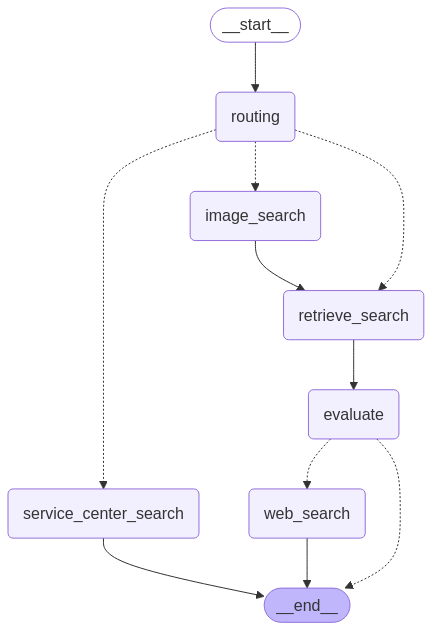

In [14]:
graph

In [4]:
def retrieve_or_image_node(state: AgentState) -> Command[Literal["retrieve_search", "image_search"]]:
    # 첫 번째 메시지의 content를 가져옵니다.
    user_query = state["messages"][0].content
    
    # 이미지 URL(또는 로컬 경로)이 포함되어 있는지 검사
    match = re.search(IMAGE_PATTERN, user_query, flags=re.IGNORECASE)
    if match:
        image_url = match.group(0)  # 첫 번째 매칭된 이미지 URL 추출
        updated_query = re.sub(IMAGE_PATTERN, '', user_query, count=1, flags=re.IGNORECASE).strip()
        state["messages"][0].content = updated_query
        state["image"] = image_url

        return Command(update={'messages': state['messages'], 'image': state['image']}, goto="image_search")
    else:
        return Command(update={'messages': state['messages']}, goto="retrieve_search")

In [5]:
def image_search_node(state: AgentState) -> Command:
    target_image_path = state["image"]
    target_image = Image.open(target_image_path).convert("RGB")

    # 저장된 아이콘 이미지 임베딩 로딩 또는 계산 함수
    def compute_and_save_embeddings():
        embeddings = {}
        for filename in os.listdir(icon_folder):
            if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
                continue
            image_path = os.path.join(icon_folder, filename)
            # imread_unicode와 resize_image는 사용자의 이미지 전처리 함수라고 가정합니다.
            img_cv = imread_unicode(image_path)
            if img_cv is None:
                continue
            img_cv = resize_image(img_cv, max_dim=500)
            # 이미지 전처리 (PIL 이미지로 변환 후 CLIP 전처리)
            img_pil = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
            input_tensor = preprocess(img_pil).unsqueeze(0).to(device)
            with torch.no_grad():
                embedding = model.encode_image(input_tensor)
            embedding /= embedding.norm(dim=-1, keepdim=True)
            embeddings[filename] = embedding.cpu()  # CPU로 이동하여 저장
        # 임베딩 저장 (pickle 사용)
        with open(embeddings_path, "wb") as f:
            pickle.dump(embeddings, f)
        
    def load_embeddings():
        if os.path.exists(embeddings_path):
            with open(embeddings_path, "rb") as f:
                embeddings = pickle.load(f)
            return embeddings
        else:
            return None

    # 저장된 임베딩이 없다면 계산하고 저장
    icon_embeddings = load_embeddings()
    if icon_embeddings is None:
        compute_and_save_embeddings()
        icon_embeddings = load_embeddings()

    # 타겟 이미지 전처리 및 임베딩 추출, 정규화
    target_input = preprocess(target_image).unsqueeze(0).to(device)
    with torch.no_grad():
        target_embedding = model.encode_image(target_input) 
    target_embedding /= target_embedding.norm(dim=-1, keepdim=True)

    # 저장된 임베딩과 타겟 이미지 간의 유사도 계산
    results = []
    for filename, embedding in icon_embeddings.items():
        # 각 임베딩은 [1, D] 형태이므로 내적을 통해 코사인 유사도를 계산
        similarity = (target_embedding.cpu() @ embedding.T).item()
        results.append((filename, similarity))

    # 유사도 내림차순 정렬
    results.sort(key=lambda x: x[1], reverse=True)
    state["image"] = results[0][0]

    # state에 추가된 정보를 포함하여 업데이트된 state를 반환
    return Command(update=state)


In [6]:
pinecone_api_key = os.getenv("PINECONE_API_KEY")
pc = Pinecone(api_key=pinecone_api_key)
index_name = "kcc"
# text-embedding-ada-002 모델의 임베딩 차원은 1536입니다.
if index_name not in [idx.name for idx in pc.list_indexes()]:
    pc.create_index(
        name=index_name,
        dimension=3072,
        metric="cosine",
    )

# Pinecone 인덱스 로드
index = pc.Index(index_name)
database = PineconeVectorStore(index_name=index_name, embedding=embedding)


In [7]:
def get_file_hash(filename):
    """파일의 SHA-256 해시값을 계산합니다."""
    h = hashlib.sha256()
    with open(filename, 'rb') as f:
        h.update(f.read())
    return h.hexdigest()

def load_stored_hash(hash_file):
    """저장된 해시값을 읽어옵니다."""
    try:
        with open(hash_file, "r", encoding="utf-8") as f:
            return f.read().strip()
    except FileNotFoundError:
        return None

def save_hash(hash_file, hash_value):
    """해시값을 파일에 저장합니다."""
    with open(hash_file, "w", encoding="utf-8") as f:
        f.write(hash_value)

In [8]:
hash_file = "test.json.hash"
current_hash = get_file_hash("test.json")
stored_hash = load_stored_hash(hash_file)

if stored_hash != current_hash:
    json_file = "test.json"
    with open(json_file, "r", encoding="utf-8") as f:
        test_data = json.load(f)

    # Document 객체 리스트 생성
    documents = []

    for item in test_data:
        pdf_file = item.get("pdf_file", "")
        structure = item.get("structure", [])

        for i, section in enumerate(structure):
            title = section.get("title", "")
            sub_titles = section.get("sub_titles", [])
            content_text = title  # 섹션 텍스트 시작
            image_paths = []      # 이미지 경로 저장 리스트

            for sub in sub_titles:
                sub_title = sub.get("title", "")
                contents = sub.get("contents", [])

                # 이미지 경로 추출
                for content in contents:
                    if content.lower().endswith(('.jpeg', '.jpg', '.png', '.gif')):
                        image_paths.append(content)

                # 일반 텍스트 내용 결합 (이미지 경로 제외)
                non_image_contents = [c for c in contents if not c.lower().endswith(('.jpeg', '.jpg', '.png', '.gif'))]
                content_text += "\n" + sub_title + "\n" + "\n".join(non_image_contents)

            # Document 객체 생성
            metadata = {
                "pdf_file": pdf_file,
                "section_title": title,
                "image_paths": json.dumps(image_paths)  # 리스트를 문자열로 변환
            }
            documents.append(Document(page_content=content_text, metadata=metadata))
    # Pinecone 벡터 스토어에 데이터 추가
    database.add_documents(documents)

In [9]:
llm = ChatOpenAI(model='gpt-4o')

In [10]:
retriever = database.as_retriever(search_kwargs={"k": 3})

In [16]:
@tool
def vector_retrieve_tool(query: str) -> List[Document]:
    """Retrieve documents based on the given query."""
    return retriever.invoke(query)

def dynamic_state_modifier(agent_input: AgentState) -> str:
    image_val = agent_input.get("image", "no_image")

    return (
        f"You are an expert on Mercedes Benz {car_type} car manuals. "
        f"The Topic of the provided target image is {image_val}. "
        "Please consider the information you provided and reply with facts (not opinions). "
        "Translate the answer into Korean and format each item on a separate line. "
        "## {{제목}}\n"
        "Example: Mercedes Benz EQS: Driver Display Charge Status Window Function\n\n"
        "### {{주요 정보}}\n"
        "- Feature Summary and Key Points\n\n"
        "### {{상세 설명}}\n"
        "- Detailed description of features\n\n"
    )


def retrieve_search_node(state: AgentState) -> Command:
    retrieve_search_agent = create_react_agent(
        llm,
        tools=[vector_retrieve_tool],
        state_modifier=dynamic_state_modifier(state)  # 함수로 교체
    )
    result = retrieve_search_agent.invoke(state)
    # 내부 retrieval 결과를 상태에 저장
    state["retrieve_result"] = result['messages'][-1].content
    
    # 사용자 쿼리를 state에서 추출 (첫 번째 메시지가 HumanMessage라고 가정)
    user_query = state["messages"][0].content
    # retriever를 직접 호출하여 Document 리스트를 가져옴
    docs = retriever.invoke(user_query)
    
    displayed_image = None
    for doc in docs:
        meta = doc.metadata
        if "image_paths" in meta and meta["image_paths"]:
            try:
                # image_paths는 json.dumps로 저장되어 있으므로 디코딩
                image_paths = json.loads(meta["image_paths"])
            except Exception:
                image_paths = meta["image_paths"]
            if isinstance(image_paths, list) and len(image_paths) > 0:
                displayed_image = image_paths[0]
                break
    # retrieval 결과 앞에 이미지 링크(존재할 경우) 추가
    state["retrieve_result"] = (displayed_image or "") + '\n\n' + state["retrieve_result"] + "\n"
    
    # 기존 messages 리스트에 retrieval 결과를 추가
    state.setdefault("messages", []).append(
        HumanMessage(content=state["retrieve_result"], name="retrieve_search")
    )
    # 전체 messages 리스트를 업데이트
    return Command(update={'messages': state["messages"]})


In [ ]:
def evaluate_node(state: AgentState) -> Command[Literal['web_search', END]]:
    retrieve_result = state.get("retrieve_result", "").strip()

    if retrieve_result == "":
        print("검색 결과가 없습니다. 웹 검색을 시도합니다.")
        return Command(goto='web_search')

    # retrieval 결과가 충분할 수 있으므로 LLM 평가 프롬프트 실행
    eval_prompt = PromptTemplate.from_template(
        "You are an expert on Mercedes Benz " + car_type + " car manuals."
        "Please rate if the retrive results below provide sufficient answers."
        "You must assess that the answers or answers of more than 200 characters are sufficiently consistent with your question."
        "If you don't have enough information to judge, or if you don't provide it in your answer, answer 'yes', and answer 'no' if enough is enough.\n\n"
        "Retrieve Results:\n{result}"
    )
    eval_chain = eval_prompt | llm
    evaluation = eval_chain.invoke({"result": state.get("retrieve_result")})
    if "yes" in evaluation.content.lower():
          print("답변이 충분하지 않습니다. 웹 검색을 시도합니다.")
          return Command(goto='web_search')
    else:
          return Command(goto=END)


In [18]:
tavily_search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

web_search_agent = create_react_agent(
    llm, 
    tools=[tavily_search_tool],
    state_modifier = (
        "You are an expert on Mercedes Benz " + car_type + " car manuals."
        "Please reply to the website information in detail. Please translate the answer into Korean and print it out."
        "Please refer to the structure below to organize the website information:\n\n"
        "## {{제목}}\n"
        "Example: Mercedes Benz EQS: Driver Display Charge Status Window Function\n\n"
        "### {{주요 정보}}\n"
        "- Feature Summary and Key Points\n\n"
        "### {{상세 설명}}\n"
        "- Detailed description of the feature. / {{source}}: website link\n\n"
        "Please translate the answer into Korean, separate each item into separate lines and print it out in a good way."
    )
)

def web_search_node(state: AgentState) -> Command:
    result = web_search_agent.invoke(state)
    state["web_result"] = result['messages'][-1].content
    state.setdefault("messages", []).append(
        HumanMessage(content=state["web_result"], name="web_search")
    )
    return Command(update={'messages': state["messages"]})


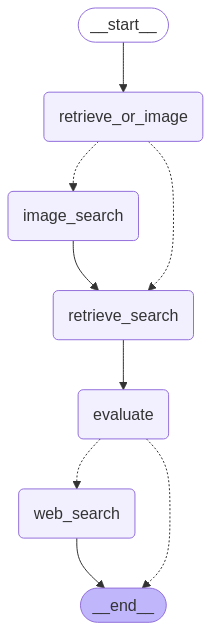

In [19]:
# 그래프 구성 (evaluate 노드에서 조건에 따라 goto가 web_search로 갈 수 있도록)
graph_builder = StateGraph(AgentState)
graph_builder.add_node("retrieve_search", retrieve_search_node)
graph_builder.add_node("evaluate", evaluate_node)
graph_builder.add_node("web_search", web_search_node)
graph_builder.add_node("image_search", image_search_node)
graph_builder.add_node("retrieve_or_image", retrieve_or_image_node)

graph_builder.add_edge(START, "retrieve_or_image")
graph_builder.add_edge("image_search", "retrieve_search")
graph_builder.add_edge("retrieve_search", "evaluate")
graph_builder.add_edge("web_search", END)

graph = graph_builder.compile()
graph

In [22]:
query = """C:/Users/suholee/Desktop/project/냉각수 기능 이상(노란색).jpeg
계기판에 이거 떴는데 뭐야?
"""
for chunk in graph.stream(
    {"messages": [HumanMessage(content=query, name="user")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================
Name: user

C:/Users/suholee/Desktop/project/냉각수 기능 이상(노란색).jpeg
계기판에 이거 떴는데 뭐야?

================================ Human Message =================================
Name: user

C:/Users/suholee/Desktop/project/냉각수 기능 이상(노란색).jpeg
계기판에 이거 떴는데 뭐야?

================================ Human Message =================================
Name: retrieve_search

C:/Users/suholee/Desktop/project/extracted_images/mercedes-eqs-sedan-manual_1.pdf_page13_0.jpeg

### 경고등 및 표시등

- 차량의 전체 전원을 켜면 일부 시스템이 자가 테스트를 실행합니다.
- 이때 일부 경고등 및 표시 등이 일시적으로 켜지거나 깜박일 수 있습니다. 이는 위험을 나타내는 신호가 아닙니다.
- 차량 시동 시 또는 주행 중 경고등 및 표시등이 켜지거나 깜박이는 경우만 기능 이상에 해당됩니다.
- 경고등 및 표시등은 강조 표시된 디스플레이 섹션에 위치합니다.

### 주의사항

- 경고등이 지속적으로 켜져 있거나 깜박이는 경우, 이는 주행에 관련된 기능에 이상이 있을 수 있음을 나타냅니다.
- 노란색 경고등은 즉각적인 위험을 나타내지 않지만, 가능한 한 빨리 확인해야 할 상황을 의미합니다.

### 해결 방법

1. 차량의 사용 설명서를 참조하여 구체적인 경고등이나 메시지의 의미를 파악합니다.
2. 필요 시 가까운 서비스 센터를 방문하여 차량의 점검을 받아야 합니다.
3. 안전을 최우선으로 고려하여 운전 중 지나친 